In [24]:
#IMPORTS
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import numpy as np
import matplotlib.pyplot as plt
import random

sys.path.append('/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Pre-processings')  
from filters import ecg_filtrado

ModuleNotFoundError: No module named 'filters'

In [25]:
import pandas as pd
import h5py
import numpy as np
import sys

# Adiciona o caminho para importar a função ecg_filtrado
sys.path.append('/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Pre-processing')  
from filters import ecg_filtrado

# Caminhos dos arquivos
csv_path = '/scratch/guilherme.evangelista/Clustering-Paper/Grafo/data/gold_standard.csv'
hdf5_path = '/scratch/guilherme.evangelista/Clustering-Paper/Grafo/data/ecg_tracings.hdf5'

# 1. Carrega o CSV
df = pd.read_csv(csv_path)

# Colunas das anomalias
anomalia_cols = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']

# 2. Cria a coluna 'normal': 1 se todas as anomalias forem 0, 0 caso contrário
df['normal'] = (df[anomalia_cols].sum(axis=1) == 0).astype(int)

# (Removido o filtro por quantidade de anomalias)

# Mantemos todo o DataFrame
df_filtered = df.copy()

# Guarda todos os índices dos exames
indices_validos = df.index.tolist()

# 4. Carrega os traçados do arquivo HDF5
with h5py.File(hdf5_path, "r") as f:
    ecg_data = np.array(f['tracings'])

print("Número original de exames:", ecg_data.shape[0])
print("Número de exames mantidos (sem filtro):", len(indices_validos))

# Filtra os traçados (na prática aqui não filtra nada, pois pegamos todos)
ecg_filtrado_array = ecg_data[indices_validos]

# 5. Aplica o pré-processamento (função ecg_filtrado) em cada lead de cada exame
ecg_processed = np.array([
    np.array([ecg_filtrado(lead) for lead in exame.T]).T
    for exame in ecg_filtrado_array
])

# 6. Salva os novos arquivos
# Salva o CSV filtrado (com a coluna 'normal' adicionada)
df_filtered.to_csv('gold_standard_filtered.csv', index=False)
print("Arquivo CSV (sem filtro por quantidade de doenças) salvo como 'gold_standard_filtered.csv'.")

# Salva o dataset processado em um novo arquivo HDF5
with h5py.File('ecg_tracings_filtered.hdf5', "w") as f_out:
    f_out.create_dataset('tracings', data=ecg_processed)
print("Arquivo HDF5 (sem filtro por quantidade de doenças) salvo como 'ecg_tracings_filtered.hdf5'.")


Número original de exames: 827
Número de exames mantidos (sem filtro): 827
Arquivo CSV (sem filtro por quantidade de doenças) salvo como 'gold_standard_filtered.csv'.
Arquivo HDF5 (sem filtro por quantidade de doenças) salvo como 'ecg_tracings_filtered.hdf5'.


Número de exames no arquivo: 827


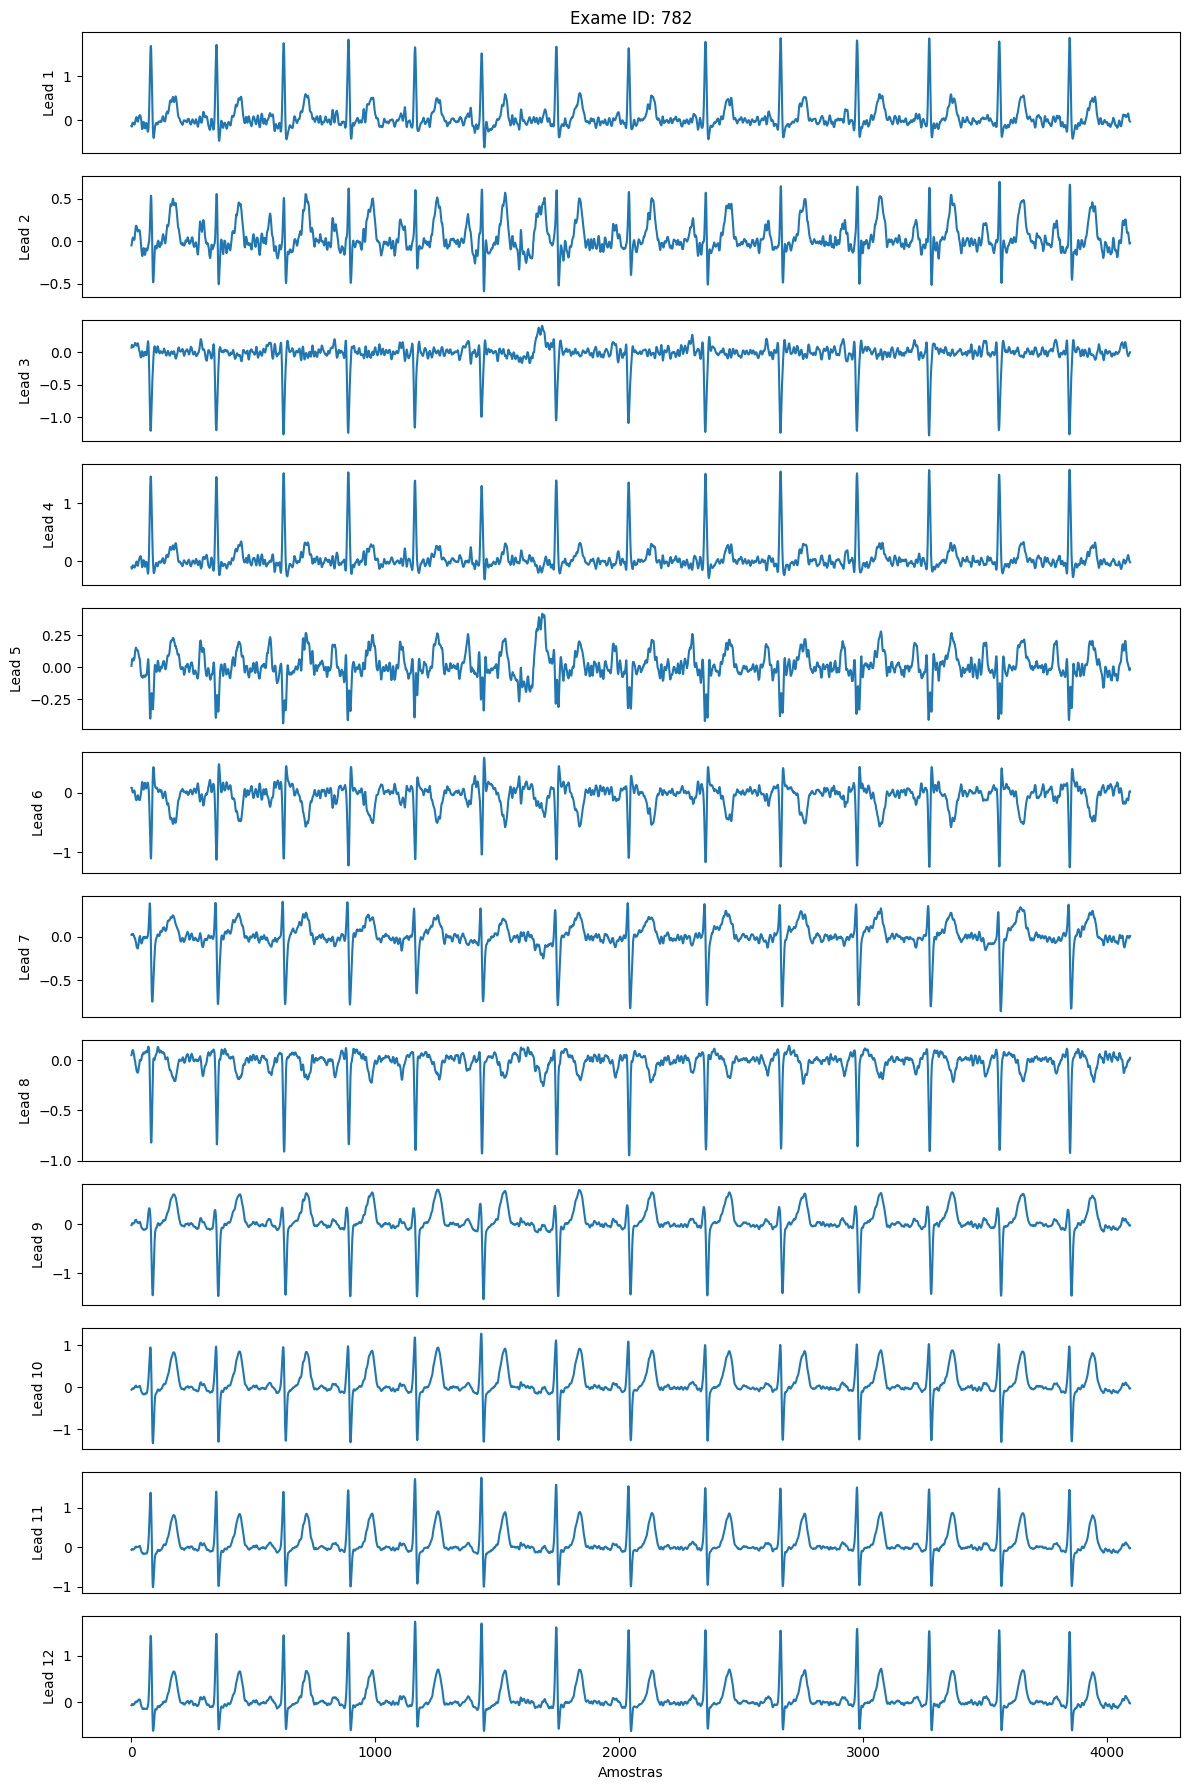

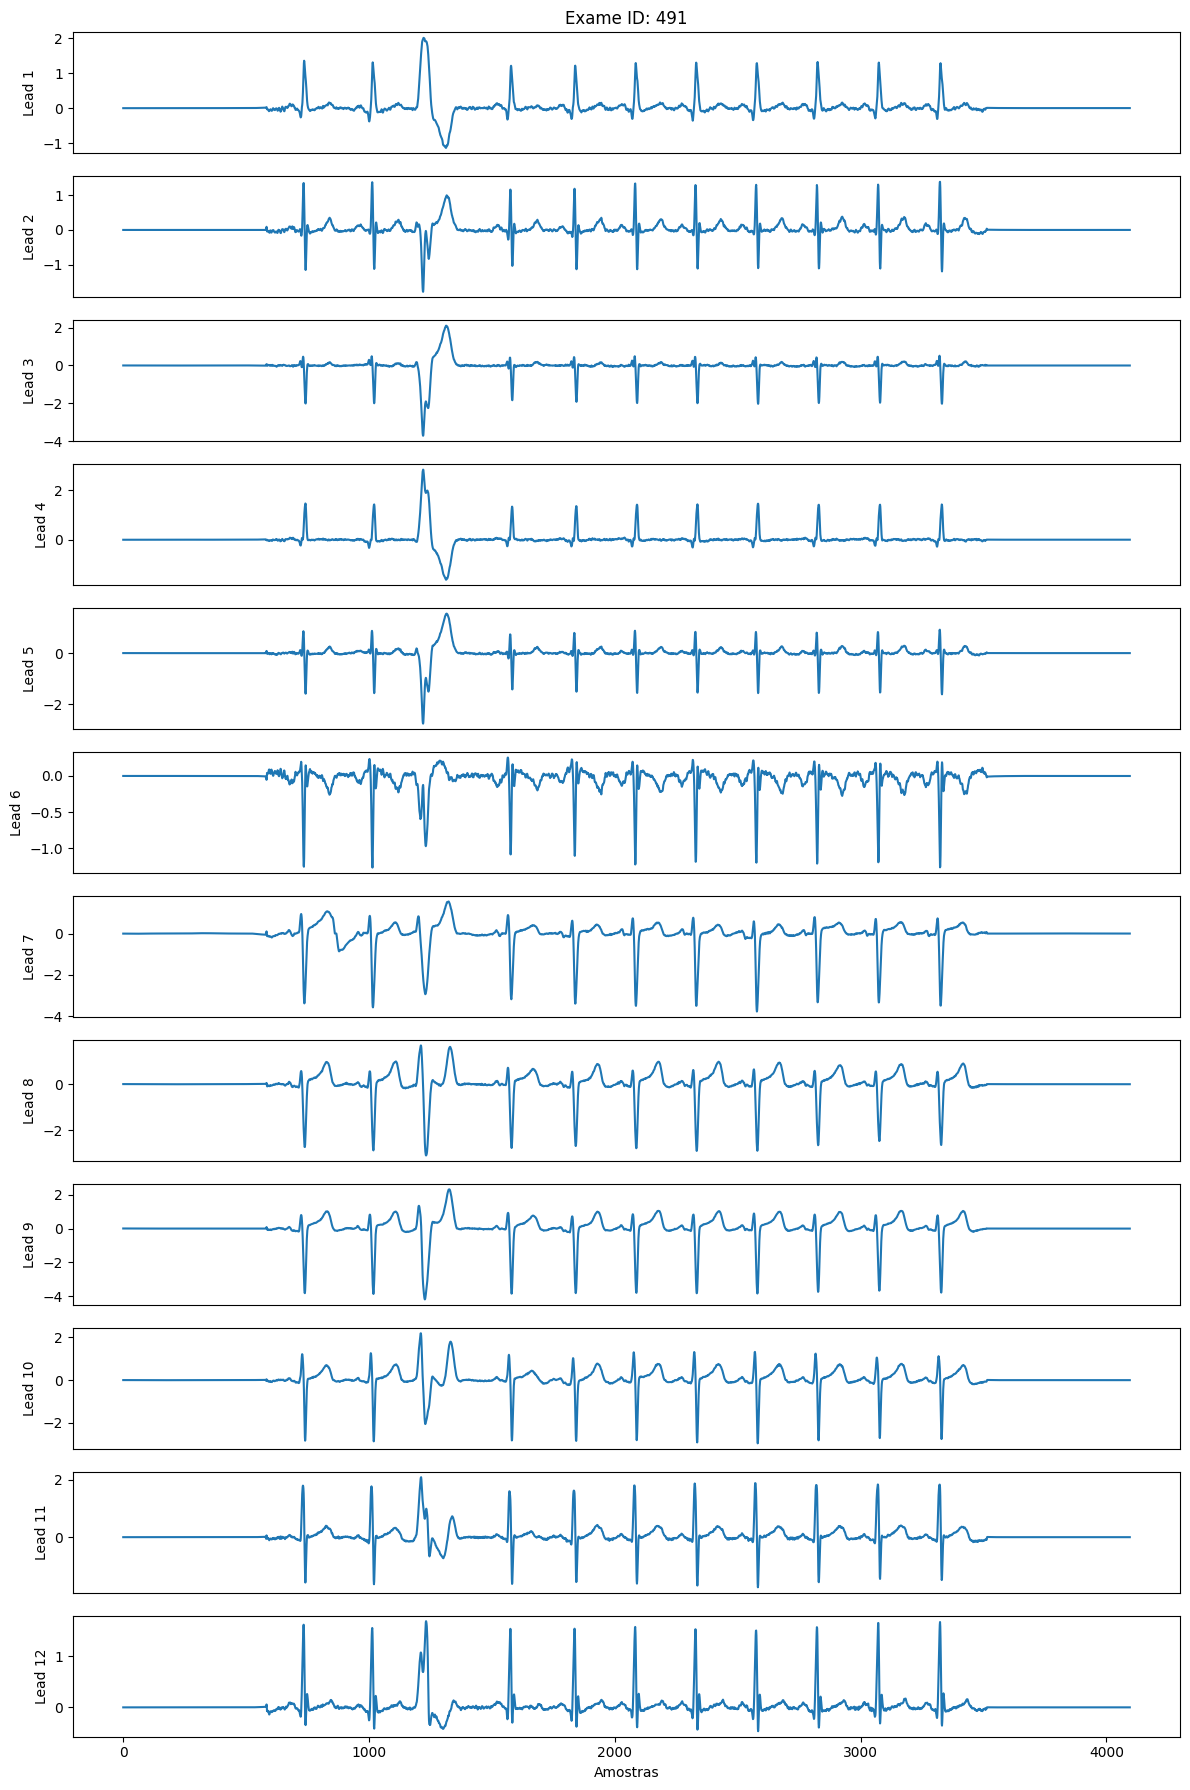

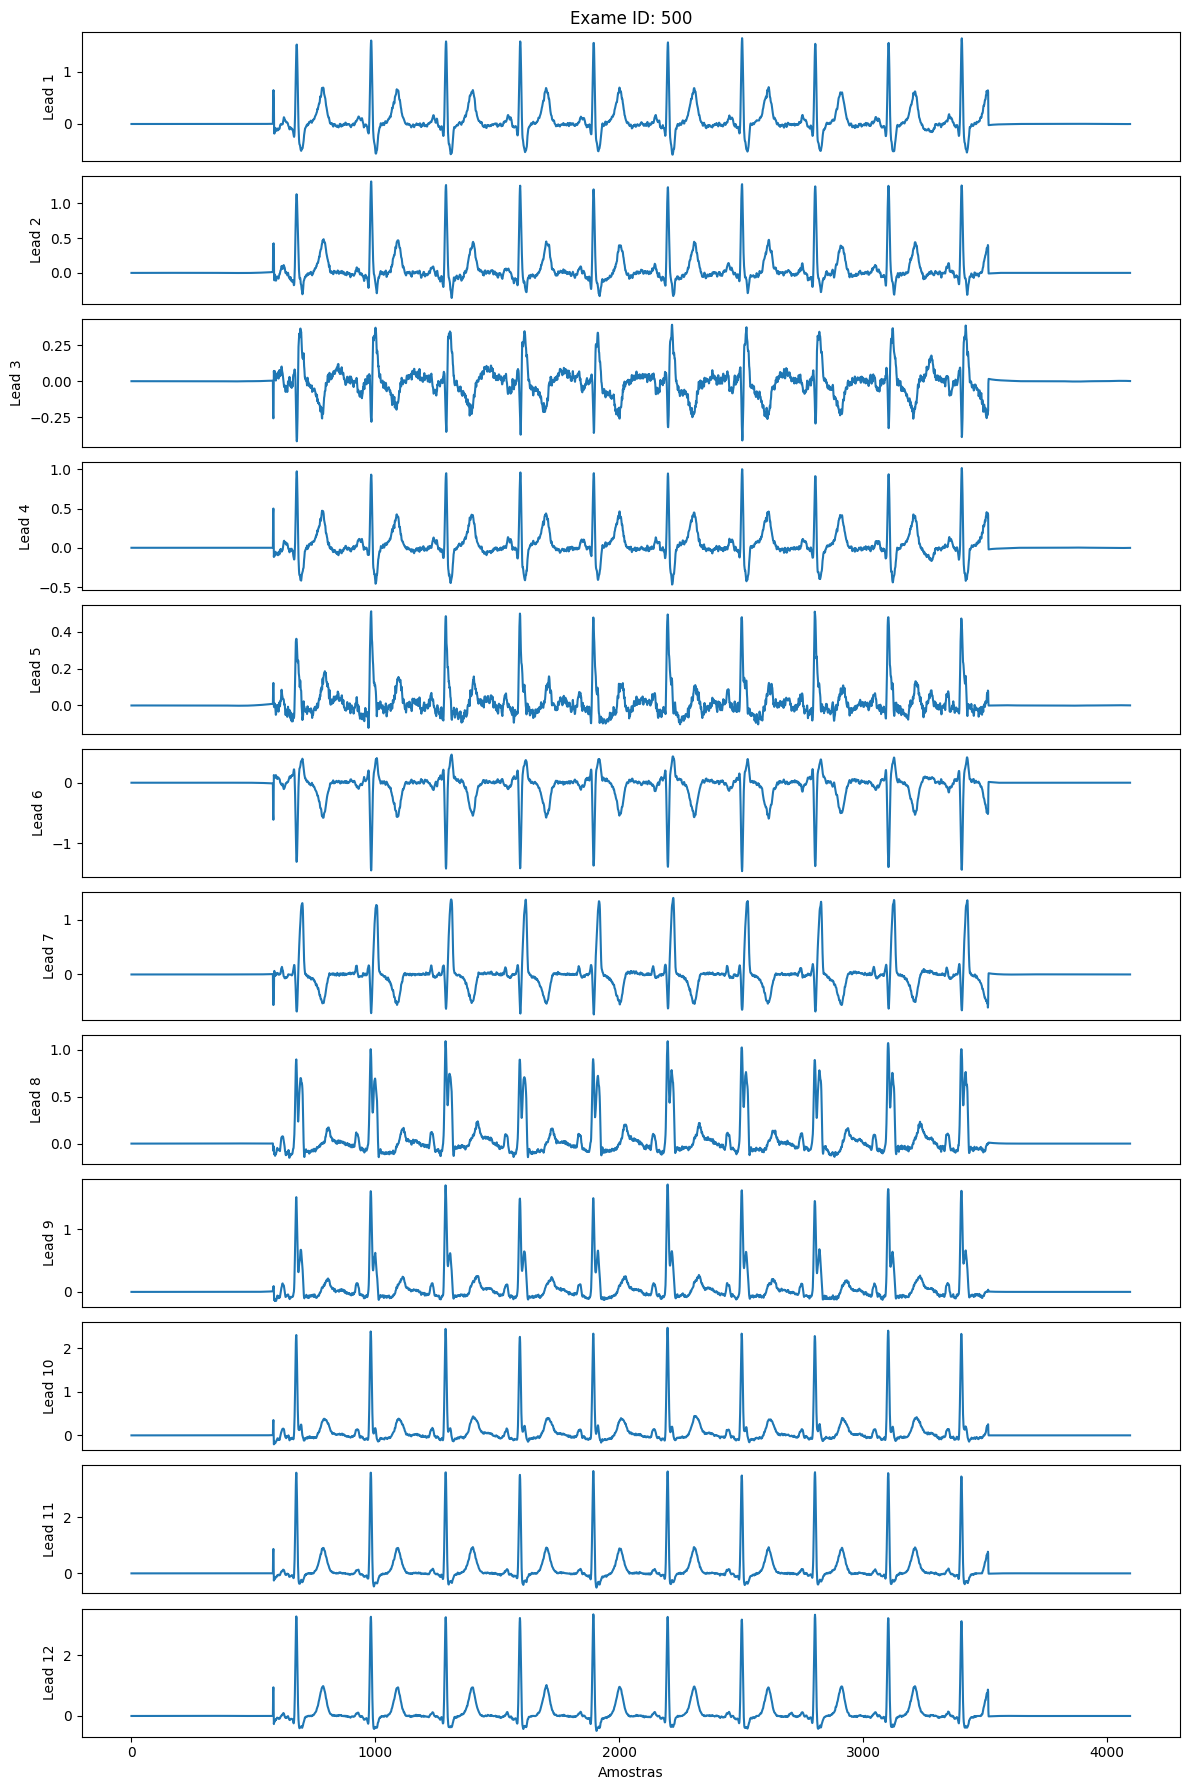

In [26]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Caminho para o arquivo HDF5 filtrado
hdf5_path = '/scratch/guilherme.evangelista/Clustering-Paper/Grafo/dataset/ecg_tracings_filtered.hdf5'

# Carregar os traçados do arquivo
with h5py.File(hdf5_path, 'r') as f:
    ecg_data = np.array(f['tracings'])

print(f"Número de exames no arquivo: {ecg_data.shape[0]}")

# Número de exames que queremos plotar (exemplo: 3 exames)
num_exames_plot = 3

# Seleciona aleatoriamente alguns índices para plotar
indices_plot = np.random.choice(ecg_data.shape[0], num_exames_plot, replace=False)

for idx in indices_plot:
    exame = ecg_data[idx]  # Shape: (4096, 12)
    
    # Cria uma figura para o exame atual
    plt.figure(figsize=(12, 18))
    
    # Plota cada uma das 12 derivações em um subplot diferente
    for lead in range(12):
        plt.subplot(12, 1, lead + 1)
        plt.plot(exame[:, lead])
        plt.ylabel(f"Lead {lead+1}")
        if lead == 0:
            plt.title(f"Exame ID: {idx}")
        if lead < 11:
            plt.xticks([])  # Remove os ticks do eixo x para subplots intermediários
    plt.xlabel("Amostras")
    plt.tight_layout()
    plt.show()


In [32]:
import pandas as pd
import numpy as np
import h5py
import random

def carregar_ecgs_goldstandard(unlabel, umdavb, rbbb, lbbb, sb, st, af, multilabel,
                               unlabel_offset=0, umdavb_offset=0, rbbb_offset=0,
                               lbbb_offset=0, sb_offset=0, st_offset=0, af_offset=0, multilabel_offset=0,
                               filtrado=False):
    """
    Carrega ECGs a partir do CSV 'gold_standard_filtered.csv' e retorna:
      - X: array numpy com os traçados de ECG, shape (N, 12, num_amostras)
      - ids_ecgs: lista com os exam_id correspondentes
      - labels: array numpy de shape (N, 6), onde cada linha contém [1dAVb, RBBB, LBBB, SB, ST, AF].
                Se todos forem 0, o exame é considerado normal.

    Parâmetros de quantidade:
      unlabel    : número de ECGs 'normais' (coluna normal == 1)
      umdavb     : número de ECGs com 1dAVb (apenas se essa for a única doença)
      rbbb       : número de ECGs com RBBB (apenas se essa for a única doença)
      lbbb       : número de ECGs com LBBB (apenas se essa for a única doença)
      sb         : número de ECGs com SB (apenas se essa for a única doença)
      st         : número de ECGs com ST (apenas se essa for a única doença)
      af         : número de ECGs com AF (apenas se essa for a única doença)
      multilabel : número de ECGs multilabel (com pelo menos duas doenças dentre as 6)

    Parâmetros de offset (para fatiamento sequencial):
      unlabel_offset    : índice inicial para pegar ECGs normais
      umdavb_offset     : índice inicial para ECGs 1dAVb
      rbbb_offset       : índice inicial para ECGs RBBB
      lbbb_offset       : índice inicial para ECGs LBBB
      sb_offset         : índice inicial para ECGs SB
      st_offset         : índice inicial para ECGs ST
      af_offset         : índice inicial para ECGs AF
      multilabel_offset : índice inicial para ECGs multilabel

    filtrado:
      Se True, carrega de '/scratch/guilherme.evangelista/Clustering-Paper/Grafo/dataset/ecg_tracings_filtered.hdf5'
      Se False, de '/scratch/guilherme.evangelista/Clustering-Paper/Grafo/data/ecg_tracings.hdf5'

    Retorna:
      X        : array com os traçados (N, 12, num_amostras)
      ids_ecgs : lista de exam_ids selecionados
      labels   : array (N, 6) com as labels [1dAVb, RBBB, LBBB, SB, ST, AF]
    """
    csv_path = '/scratch/guilherme.evangelista/Clustering-Paper/Grafo/dataset/gold_standard_filtered.csv'
    dados = pd.read_csv(csv_path)
    
    # Se a coluna 'exam_id' não existir, cria-a com números aleatórios
    if 'exam_id' not in dados.columns:
        dados.insert(0, 'exam_id', [random.randint(10000, 99999) for _ in range(len(dados))])
        dados.to_csv(csv_path, index=False)
        print("Coluna 'exam_id' criada e CSV atualizado.")
    
    # Calcula a soma dos sinais de doença para identificar multilabel
    bool_sum = (dados['1dAVb'].astype(int) +
                dados['RBBB'].astype(int) +
                dados['LBBB'].astype(int) +
                dados['SB'].astype(int) +
                dados['ST'].astype(int) +
                dados['AF'].astype(int))
    
    # Seleciona linhas para os casos multilabel (pelo menos duas doenças)
    ecg_multilabel_linhas = dados.index[bool_sum >= 2]
    
    # Seleciona os exames de cada categoria, excluindo os multilabel
    ecg_normal_linhas  = dados.index[dados['normal'] == 1]
    ecg_umdavb_linhas  = dados.index[(dados['1dAVb'] == 1) & (~dados.index.isin(ecg_multilabel_linhas))]
    ecg_rbbb_linhas    = dados.index[(dados['RBBB'] == 1) & (~dados.index.isin(ecg_multilabel_linhas))]
    ecg_lbbb_linhas    = dados.index[(dados['LBBB'] == 1) & (~dados.index.isin(ecg_multilabel_linhas))]
    ecg_sb_linhas      = dados.index[(dados['SB'] == 1) & (~dados.index.isin(ecg_multilabel_linhas))]
    ecg_st_linhas      = dados.index[(dados['ST'] == 1) & (~dados.index.isin(ecg_multilabel_linhas))]
    ecg_af_linhas      = dados.index[(dados['AF'] == 1) & (~dados.index.isin(ecg_multilabel_linhas))]
    
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))
    print("Número de linhas ecg_multilabel_linhas:", len(ecg_multilabel_linhas))

    # Obtém os exam_ids para cada categoria
    ecg_normal_ids      = dados.loc[ecg_normal_linhas, 'exam_id'].tolist()
    ecg_umdavb_ids      = dados.loc[ecg_umdavb_linhas, 'exam_id'].tolist()
    ecg_rbbb_ids        = dados.loc[ecg_rbbb_linhas, 'exam_id'].tolist()
    ecg_lbbb_ids        = dados.loc[ecg_lbbb_linhas, 'exam_id'].tolist()
    ecg_sb_ids          = dados.loc[ecg_sb_linhas, 'exam_id'].tolist()
    ecg_st_ids          = dados.loc[ecg_st_linhas, 'exam_id'].tolist()
    ecg_af_ids          = dados.loc[ecg_af_linhas, 'exam_id'].tolist()
    ecg_multilabel_ids  = dados.loc[ecg_multilabel_linhas, 'exam_id'].tolist()

    # Função auxiliar para fatiar a lista com um offset
    def slice_ids(id_list, offset, count):
        if offset >= len(id_list):
            return []
        return id_list[offset : offset + count]

    # Seleciona os blocos desejados usando slicing (não aleatório)
    ecg_normal_sample     = slice_ids(ecg_normal_ids,     unlabel_offset,    unlabel)
    ecg_umdavb_sample     = slice_ids(ecg_umdavb_ids,     umdavb_offset,     umdavb)
    ecg_rbbb_sample       = slice_ids(ecg_rbbb_ids,       rbbb_offset,       rbbb)
    ecg_lbbb_sample       = slice_ids(ecg_lbbb_ids,       lbbb_offset,       lbbb)
    ecg_sb_sample         = slice_ids(ecg_sb_ids,         sb_offset,         sb)
    ecg_st_sample         = slice_ids(ecg_st_ids,         st_offset,         st)
    ecg_af_sample         = slice_ids(ecg_af_ids,         af_offset,         af)
    ecg_multilabel_sample = slice_ids(ecg_multilabel_ids, multilabel_offset, multilabel)

    # Combina os exam_ids selecionados. Note que as amostras multilabel são adicionadas de forma separada.
    ids_ecgs = list(dict.fromkeys(
        ecg_normal_sample +
        ecg_umdavb_sample +
        ecg_rbbb_sample +
        ecg_lbbb_sample +
        ecg_sb_sample +
        ecg_st_sample +
        ecg_af_sample +
        ecg_multilabel_sample
    ))
    
    print("Número total de ECGs no CSV:", len(dados))
    print("Número de ECGs selecionados:", len(ids_ecgs))
    
    # Define o(s) arquivo(s) HDF5 a serem utilizados
    if filtrado:
        arquivos_hdf5 = ['/scratch/guilherme.evangelista/Clustering-Paper/Grafo/dataset/ecg_tracings_filtered.hdf5']
    else:
        arquivos_hdf5 = ['/scratch/guilherme.evangelista/Clustering-Paper/Grafo/data/ecg_tracings.hdf5']
    
    # Função auxiliar para obter os dados do exame a partir do HDF5 usando exam_id
    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            if 'exam_id' in f.keys():
                exam_ids = np.array(f['exam_id'])
                exam_index = np.where(exam_ids == exam_id)[0]
                if len(exam_index) == 0:
                    raise ValueError(f"Exam ID {exam_id} não encontrado.")
                exam_index = exam_index[0]
            else:
                # Se não houver dataset exam_id, assume que a ordem é a mesma do CSV
                exam_index = np.where(dados['exam_id'] == exam_id)[0][0]
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

    # Carrega os traçados de ECG para cada exam_id selecionado
    all_tracings = []
    for exam_id in ids_ecgs:
        found = False
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    # Transpõe para o formato (12, N_amostras)
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True
                    break
            except Exception:
                pass
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")
    
    print("Número de ECGs que eram pra ser processados:", len(ids_ecgs))
    print("Número total de traçados processados:", len(all_tracings))
    
    X = np.array(all_tracings)
    print("Shape de X:", X.shape)
    
    # Gerar labels: para cada exame, o label é um vetor de 6 posições: [1dAVb, RBBB, LBBB, SB, ST, AF]
    labels = []
    for eid in ids_ecgs:
        row = dados.loc[dados['exam_id'] == eid]
        if len(row) == 0:
            labels.append([0, 0, 0, 0, 0, 0])
        else:
            row = row.iloc[0]
            label = [
                int(row['1dAVb']),
                int(row['RBBB']),
                int(row['LBBB']),
                int(row['SB']),
                int(row['ST']),
                int(row['AF'])
            ]
            labels.append(label)
    labels = np.array(labels, dtype=int)
    
    return X, ids_ecgs, labels

#

In [56]:
# Exemplo de chamada da função:
X, ids_ecgs, labels = carregar_ecgs_goldstandard(
     unlabel=0,    unlabel_offset=0,
     umdavb=0,      umdavb_offset=0,
     rbbb=0,       rbbb_offset=0,
     lbbb=0,        lbbb_offset=0,
     sb=0,          sb_offset=0,
     st=37,          st_offset=0,
     af=13,         af_offset=0,
     multilabel=12,  multilabel_offset=0,
     filtrado=True
)

Número de linhas ecg_normal_linhas: 681
Número de linhas ecg_umdavb_linhas: 20
Número de linhas ecg_rbbb_linhas: 28
Número de linhas ecg_lbbb_linhas: 25
Número de linhas ecg_sb_linhas: 15
Número de linhas ecg_st_linhas: 35
Número de linhas ecg_af_linhas: 11
Número de linhas ecg_multilabel_linhas: 12
Número total de ECGs no CSV: 827
Número de ECGs selecionados: 58
Número de ECGs que eram pra ser processados: 58
Número total de traçados processados: 58
Shape de X: (58, 12, 4096)


In [57]:
# Vamos imprimir um exemplo de 10 exames, mostrando seu exam_id e respectivo label
for i in range(min(100, len(ids_ecgs))):
    print(f"Exam ID: {ids_ecgs[i]}, Label: {labels[i]}")


Exam ID: 24, Label: [0 0 0 0 1 0]
Exam ID: 34, Label: [0 0 0 0 1 0]
Exam ID: 70, Label: [0 0 0 0 1 0]
Exam ID: 109, Label: [0 0 0 0 1 0]
Exam ID: 127, Label: [0 0 0 0 1 0]
Exam ID: 129, Label: [0 0 0 0 1 0]
Exam ID: 138, Label: [0 0 0 0 1 0]
Exam ID: 149, Label: [0 0 0 0 1 0]
Exam ID: 167, Label: [0 0 0 0 1 0]
Exam ID: 179, Label: [0 0 0 0 1 0]
Exam ID: 185, Label: [0 0 0 0 1 0]
Exam ID: 196, Label: [0 0 0 0 1 0]
Exam ID: 248, Label: [0 0 0 0 1 0]
Exam ID: 310, Label: [0 0 0 0 1 0]
Exam ID: 377, Label: [0 0 0 0 1 0]
Exam ID: 398, Label: [0 0 0 0 1 0]
Exam ID: 418, Label: [0 0 0 0 1 0]
Exam ID: 440, Label: [0 0 0 0 1 0]
Exam ID: 459, Label: [0 0 0 0 1 0]
Exam ID: 482, Label: [0 0 0 0 1 0]
Exam ID: 493, Label: [0 0 0 0 1 0]
Exam ID: 504, Label: [0 0 0 0 1 0]
Exam ID: 544, Label: [0 0 0 0 1 0]
Exam ID: 546, Label: [0 0 0 0 1 0]
Exam ID: 564, Label: [0 0 0 0 1 0]
Exam ID: 582, Label: [0 0 0 0 1 0]
Exam ID: 614, Label: [0 0 0 0 1 0]
Exam ID: 630, Label: [0 0 0 0 1 0]
Exam ID: 660, Label: [0

In [40]:
import torch
import numpy as np
import neurokit2 as nk
import networkx as nx  # <- Import para calcular PageRank
from ts2vg import NaturalVG
from torch_geometric.data import Data
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_node_features(time_series, edges):
    """
    Calcula as features de cada nó:
      - amplitude: valor da amostra;
      - derivada: diferença com o nó anterior (primeiro nó = 0);
      - grau: número de arestas incidentes;
      - pagerank: valor de pagerank calculado via networkx.
    
    Parâmetros:
      time_series: numpy array de forma (n,) com os valores da lead.
      edges: lista de tuplas (i, j) definindo as arestas do grafo.
      
    Retorna:
      features: numpy array de forma (n, 4) com
                [amplitude, derivada, grau, pagerank] para cada nó.
    """
    n = len(time_series)
    amplitude = time_series.reshape(-1, 1)
    derivative = np.concatenate(([0], np.diff(time_series))).reshape(-1, 1)
    
    if edges:
        edges_array = np.array(edges)
        # Separa nós de origem e destino
        u, v = edges_array[:, 0], edges_array[:, 1]
        counts = np.bincount(np.concatenate([u, v]), minlength=n)
    else:
        counts = np.zeros(n)
    degree = counts.reshape(-1, 1)
    
    # Cálculo do PageRank usando NetworkX
    if edges:
        G = nx.Graph()
        G.add_nodes_from(range(n))    # garante que todos os nós estejam no grafo
        G.add_edges_from(edges)
        pr_values = nx.pagerank(G)    # dicionário {nó: pagerank}
        pagerank_arr = np.array([pr_values[i] for i in range(n)]).reshape(-1, 1)
    else:
        pagerank_arr = np.zeros((n, 1))

    features = np.hstack([amplitude, derivative, degree, pagerank_arr])
    return features


def get_middle_r_peak(lead_series, sampling_rate=400):
    """
    Detecta os picos R na lead utilizando nk.ecg_findpeaks do NeuroKit e retorna o pico "do meio".
    Caso nenhum pico seja encontrado, retorna o índice central da série.
    """
    peaks_dict = nk.ecg_findpeaks(lead_series, sampling_rate=sampling_rate)
    peaks = np.array(peaks_dict["ECG_R_Peaks"])
    if peaks.size == 0:
        return len(lead_series) // 2
    
    if len(peaks) % 2 == 0:
        middle_index = peaks[len(peaks) // 2 - 1]
    else:
        middle_index = peaks[len(peaks) // 2]
    return middle_index


def process_lead(lead_series):
    """
    Processa uma única lead:
      - Detecta o pico R "do meio" (NeuroKit).
      - Seleciona 1000 pontos centrados no R (500 antes, 500 depois).
      - Constrói o grafo de visibilidade (ts2vg.NaturalVG).
      - Calcula as features [amplitude, derivada, grau, pagerank].
      - Retorna Data(x=node_features, edge_index).
    """
    r_peak = get_middle_r_peak(lead_series, sampling_rate=400)

    start_index = max(0, r_peak - 500)
    end_index = min(len(lead_series), r_peak + 500)
    lead_segment = lead_series[start_index:end_index]

    vg = NaturalVG()
    vg.build(lead_segment)
    edges = vg.edges  # lista de arestas (i, j)
    
    node_features = compute_node_features(lead_segment, edges)

    if edges:
        edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.int64)

    node_features_tensor = torch.tensor(node_features, dtype=torch.float32)
    return Data(x=node_features_tensor, edge_index=edge_index)


def process_exam(ecg, exam_id, label):
    """
    Processa um ECG (12 leads) e retorna:
      - exam_id
      - dicionário com 12 grafos
      - label associada a esse exame.
    """
    exam_graphs = {
        f"lead_{lead_index}": process_lead(ecg[lead_index])
        for lead_index in range(12)
    }
    return exam_id, exam_graphs, label


if __name__ == '__main__':
    # ==========================================================================
    # SUPOSIÇÕES:
    #  - X, ids_ecgs e labels estão definidos e têm mesmo tamanho N.
    #  - X: (N, 12, num_amostras)
    #  - ids_ecgs: lista com N exam_ids
    #  - labels: array/list com as N labels
    # ==========================================================================
    exam_ids_list = ids_ecgs
    labels_list   = labels

    print("Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...")

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_exam)(ecg, exam_ids_list[idx], labels_list[idx])
        for idx, ecg in enumerate(tqdm(X, desc="Processando exames"))
    )

    graphs_by_exam = {
        exam_id: {
            "grafos": exam_graphs,  # as 12 leads como Data PyG
            "label": lbl
        }
        for (exam_id, exam_graphs, lbl) in results
    }

    dados_salvos = {"grafos": graphs_by_exam}

    output_filename = "codetest.pt"
    torch.save(dados_salvos, output_filename)
    print(f"Grafos (com labels e PageRank) salvos em {output_filename}")


Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...


Processando exames:   8%|▊         | 64/827 [00:18<04:11,  3.04it/s][Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.7s
Processando exames:  12%|█▏        | 96/827 [00:20<02:33,  4.78it/s][Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.0s
Processando exames:  19%|█▉        | 160/827 [00:23<01:14,  8.98it/s][Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   24.7s
Processando exames:  23%|██▎       | 192/827 [00:25<00:57, 11.07it/s][Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   26.6s
Processando exames:  31%|███       | 256/827 [00:28<00:39, 14.48it/s][Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 224 tasks

Grafos (com labels e PageRank) salvos em codetest.pt


In [48]:
import torch

# Caminho do arquivo .pt (ajuste conforme necessário)
file_path = "/scratch/guilherme.evangelista/Clustering-Paper/Grafo/dataset/codetest.pt"

try:
    # Carrega o arquivo com o checkpoint completo (weights_only=False)
    dados = torch.load(file_path, weights_only=False)
except Exception as e:
    print(f"Erro ao carregar o arquivo {file_path}: {e}")
    exit()

# Verifica o formato dos dados e conta os exames
if isinstance(dados, dict) and "grafos" in dados:
    exames = dados["grafos"]
    print(f"Número de exames (dict): {len(exames)}")
elif isinstance(dados, list):
    print(f"Número de exames (lista): {len(dados)}")
else:
    print("Formato dos dados não reconhecido.")


Número de exames (dict): 827


In [63]:
import torch

def obter_informacoes_exame(exam_id, pt_file="codetest.pt"):
    """
    Carrega o arquivo .pt, localiza o exam_id e retorna:
      - label associada ao exame
      - dicionário de grafos das 12 leads (cada lead é um objeto Data do PyG)
    """
    # Carrega o conteúdo do .pt
    dados = torch.load(pt_file, weights_only=False)

    # 'dados' é um dicionário contendo "grafos": {exam_id: {"grafos": dict_de_leads, "label": label}}
    if "grafos" not in dados:
        print("Formato de arquivo inesperado. Chave 'grafos' não encontrada.")
        return None, None

    # Tenta recuperar o dicionário para o exam_id desejado
    info_exame = dados["grafos"].get(exam_id)
    if info_exame is None:
        print(f"Exam ID {exam_id} não encontrado no arquivo.")
        return None, None

    # Pega a label e o dicionário das 12 leads
    label_exame = info_exame["label"]
    grafos_12_leads = info_exame["grafos"]

    return label_exame, grafos_12_leads


# ======================
# Exemplo de uso:
# ======================
if __name__ == "__main__":
    meu_exam_id = 138  # substitua pelo ID que você quer inspecionar
    label, grafos = obter_informacoes_exame(meu_exam_id, pt_file="codetest.pt")

    if grafos is not None:
        print(f"Label do exame {meu_exam_id}:", label)
        print("Leads disponíveis:", list(grafos.keys()))
        
        # Podemos inspecionar a estrutura de uma lead específica (ex: lead_0)
        lead0_data = grafos["lead_0"]  # objeto Data do PyTorch Geometric
        print("Nó x shape:", lead0_data.x.shape)          # (num_nós, 3) -> amplitude, derivada, grau
        print("Edge index shape:", lead0_data.edge_index.shape)  # (2, num_arestas)
        print("Exemplo de 'x':\n", lead0_data.x[:250])      # 5 primeiras linhas das features


Label do exame 138: [0 0 0 0 1 0]
Leads disponíveis: ['lead_0', 'lead_1', 'lead_2', 'lead_3', 'lead_4', 'lead_5', 'lead_6', 'lead_7', 'lead_8', 'lead_9', 'lead_10', 'lead_11']
Nó x shape: torch.Size([1000, 4])
Edge index shape: torch.Size([2, 11631])
Exemplo de 'x':
 tensor([[ 3.2870e-02,  0.0000e+00,  8.0000e+00,  9.0996e-04],
        [ 3.5167e-02,  2.2966e-03,  6.0000e+00,  7.2941e-04],
        [ 4.7444e-02,  1.2277e-02,  5.0000e+00,  6.6885e-04],
        [ 6.1814e-02,  1.4370e-02,  8.0000e+00,  1.0527e-03],
        [ 6.9505e-02,  7.6904e-03,  5.0000e+00,  7.2586e-04],
        [ 7.7793e-02,  8.2883e-03,  4.0000e+00,  6.2380e-04],
        [ 9.9794e-02,  2.2001e-02,  5.0000e+00,  7.2952e-04],
        [ 1.2974e-01,  2.9944e-02,  8.0000e+00,  1.0527e-03],
        [ 1.5331e-01,  2.3570e-02,  9.0000e+00,  9.7858e-04],
        [ 1.6670e-01,  1.3394e-02,  7.0000e+00,  5.3462e-04],
        [ 1.6736e-01,  6.5818e-04,  1.6000e+01,  9.5929e-04],
        [ 1.5880e-01, -8.5593e-03,  1.1000e+01,  6